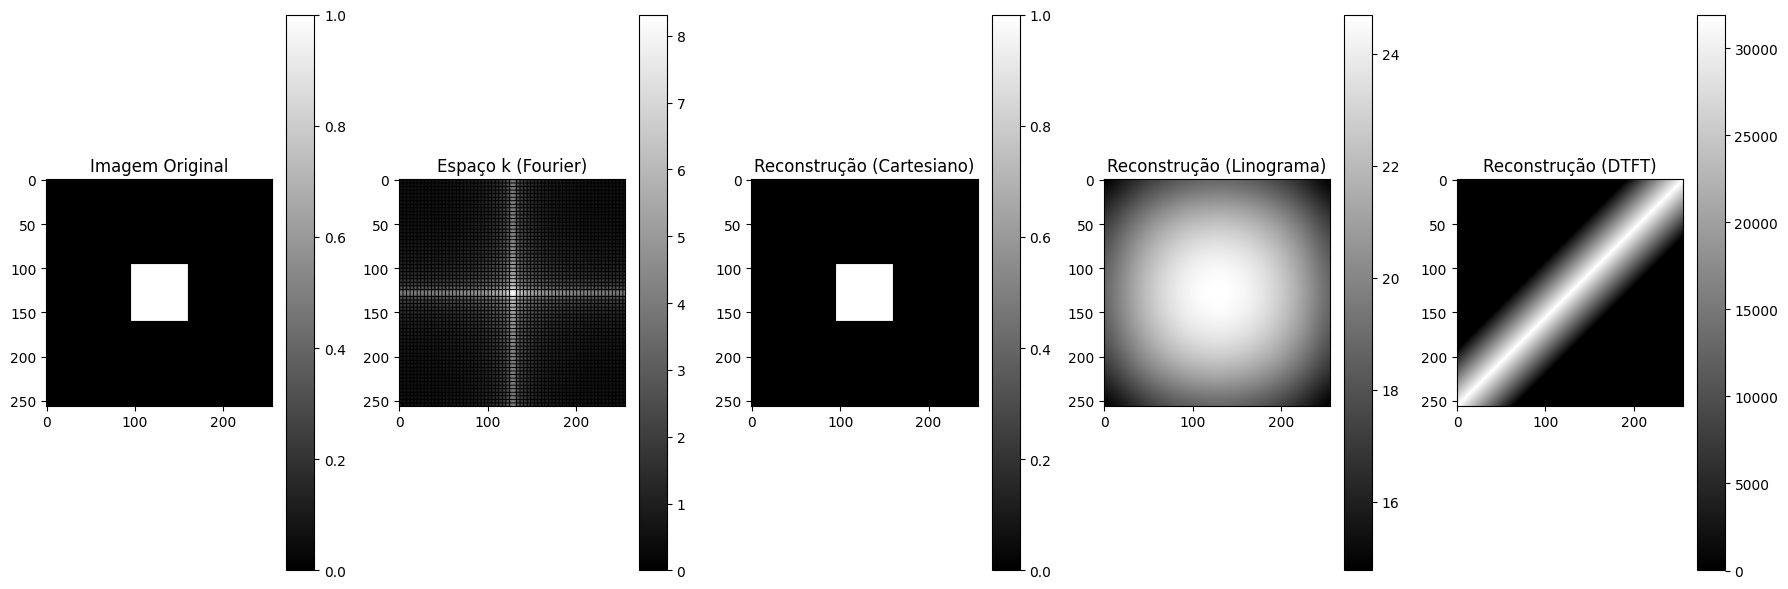

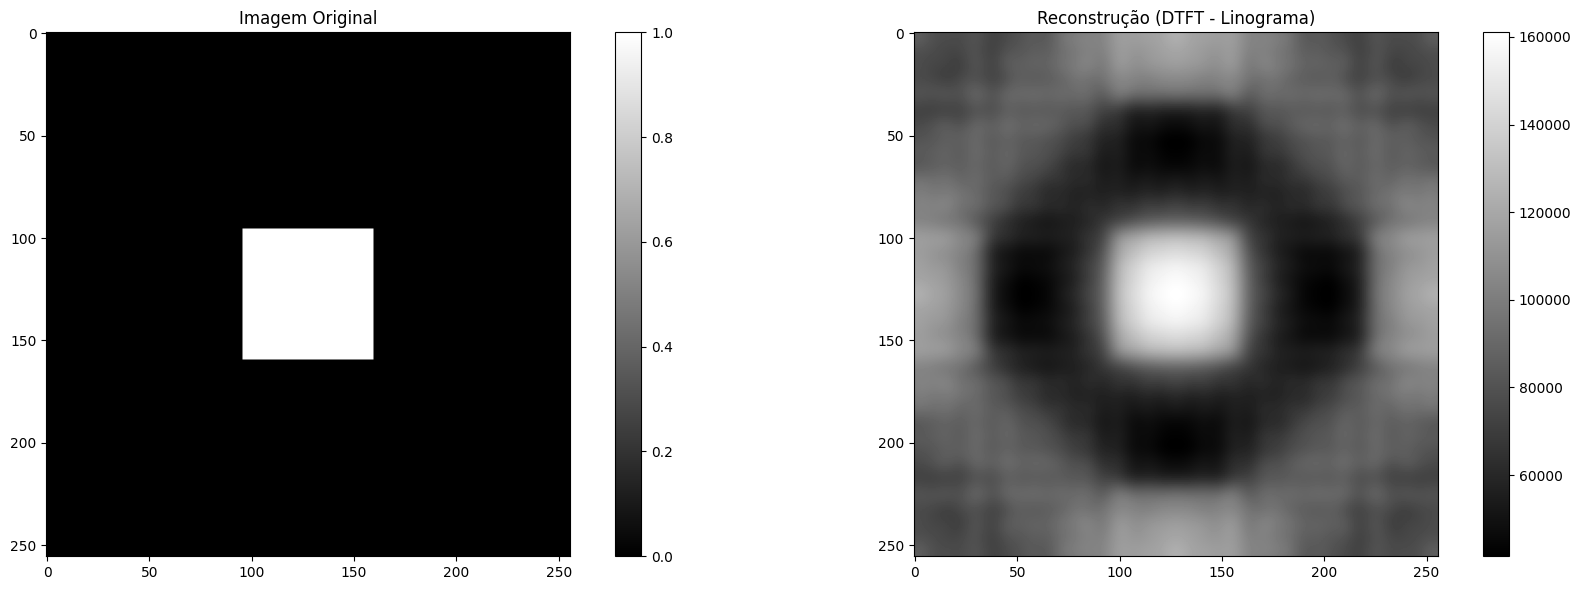

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import sigpy as sp  # Para NUFFT

# Função para gerar uma imagem original
def generate_image(image_size):
    image = np.zeros((image_size, image_size))
    image[96:160, 96:160] = 1  # Quadrado branco no centro
    return image

# Função 1: Domínio Cartesiano
def fourier_cartesian(image):
    # Transformada de Fourier
    k_space = np.fft.fftshift(np.fft.fft2(image))
    return k_space

#______________________________LINOGRAMA

# Função para gerar coordenadas do Linograma Horizontal (H)
def lino_H(M, N):
    x, y = [], []
    for I in range(-M // 2, M // 2):
        for J in range(-N // 4 + 1, N // 4 + 1):
            x.append((2 * np.pi * I) / M)
            y.append(((2 * np.pi * I) / M) * ((4 * J) / N))
    return np.array(x), np.array(y)

# Função para gerar coordenadas do Linograma Vertical (V)
def lino_V(M, N):
    x, y = [], []
    for I in range(-M // 2 + 1, M // 2 + 1):
        for J in range(-N // 4, N // 4):
            y.append((2 * np.pi * I) / M)
            x.append(((2 * np.pi * I) / M) * ((4 * J) / N))
    return np.array(x), np.array(y)

# Função para gerar o domínio do Linograma
def generate_linogram(M, N):
    x_H, y_H = lino_H(M, N)  # Coordenadas Horizontais
    x_V, y_V = lino_V(M, N)  # Coordenadas Verticais
    
    # Unindo coordenadas horizontais e verticais
    linogram_coords = np.column_stack((np.concatenate([x_H, x_V]), np.concatenate([y_H, y_V])))
    
    return linogram_coords

# Função para calcular a NUFFT no Linograma
def fourier_linogram(image, M, N):
    linogram_coords = generate_linogram(M, N)
    linogram_coords_normalized = linogram_coords / (2 * np.pi)  # Normalizar para [-0.5, 0.5]
    
    # Aplicação da NUFFT
    k_space = sp.nufft(image, linogram_coords_normalized)
    return k_space, linogram_coords_normalized

#______________________________FIM LINOGRAMA

# Visualizar os pontos do Dominio
def visualizar_dominio(dominio):
    plt.figure(figsize=(8, 8))
    plt.scatter(dominio[:, 0], dominio[:, 1], s=5, alpha=0.7, color="blue")
    plt.title("Visualização dos Pontos do DFLAD")
    plt.xlabel("Frequência Horizontal (\u03BE)")
    plt.ylabel("Frequência Vertical (\u03BD)")
    plt.grid(True)
    plt.axis("equal")
    plt.show()

# Reconstrução do Domínio Cartesiano
def inverse_cartesian(k_space):
    reconstructed_image = np.abs(np.fft.ifft2(np.fft.ifftshift(k_space)))
    return reconstructed_image

# Reconstrução do Domínio do Linograma
def inverse_linogram(k_space, coords, image_shape):
    reconstructed_image = np.abs(sp.nufft_adjoint(k_space, coords, image_shape))
    return reconstructed_image

# Função DTFT para avaliar a Transformada de Fourier em pontos arbitrários
def DTFT(x, xi, nu):
    m, n = x.shape
    x_result = np.zeros(len(xi), dtype=complex)
    
    for k in range(len(xi)):
        sum_value = 0  
        for i in range(m):
            for j in range(n):
                sum_value += x[i, j] * np.exp(-1j * (j * xi[k] + i * nu[k]))
        x_result[k] = sum_value

    return x_result

# Função para reconstruir a imagem no domínio espacial via DTFT inversa
def inverse_DTFT(k_space, xi, nu, image_shape):
    m, n = image_shape
    reconstructed = np.zeros((m, n), dtype=complex)
    
    for i in range(m):
        for j in range(n):
            sum_value = 0
            for k in range(len(xi)):
                sum_value += k_space[k] * np.exp(1j * (j * xi[k] + i * nu[k]))
            reconstructed[i, j] = sum_value

    return np.abs(reconstructed)


image_size = 256
M, N = 20, 20


original_image = generate_image(image_size)

k_space_cartesian = fourier_cartesian(original_image)
reconstructed_cartesian = inverse_cartesian(k_space_cartesian)

k_space_linogram, linogram_coords = fourier_linogram(original_image, M, N)
reconstructed_linogram = inverse_linogram(k_space_linogram, linogram_coords, original_image.shape)

# Gerar coordenadas de um domínio arbitrário (Exemplo: Domínio Cartesiano)
xi = np.linspace(-np.pi, np.pi, 500)  # Coordenadas no espaço de Fourier
nu = np.linspace(-np.pi, np.pi, 500)

k_space_dtft = DTFT(original_image, xi, nu)
reconstructed_dtft = inverse_DTFT(k_space_dtft, xi, nu, original_image.shape)

xi, nu = linogram_coords[:, 0], linogram_coords[:, 1]  # Extraindo coordenadas do Linograma

k_space_linogram_dtft = DTFT(original_image, xi, nu)
reconstructed_linogram_dtft = inverse_DTFT(k_space_linogram_dtft, xi, nu, original_image.shape)

plt.figure(figsize=(18, 6))

# Imagem Original
plt.subplot(1, 5, 1)
plt.title("Imagem Original")
plt.imshow(original_image, cmap="gray")
plt.colorbar()

# Visualizar o espaço k (magnitude)
plt.subplot(1, 5, 2)
plt.title("Espaço k (Fourier)")
plt.imshow(np.log(np.abs(k_space_cartesian) + 1), cmap="gray")  # Escala log para visualizar melhor
plt.colorbar()
#plt.show()

# Reconstrução Domínio Cartesiano
plt.subplot(1, 5, 3)
plt.title("Reconstrução (Cartesiano)")
plt.imshow(reconstructed_cartesian, cmap="gray")
plt.colorbar()

# Reconstrução Domínio Linograma
plt.subplot(1, 5, 4)
plt.title("Reconstrução (Linograma)")
plt.imshow(reconstructed_linogram, cmap="gray")
plt.colorbar()

plt.subplot(1, 5, 5)
plt.title("Reconstrução (DTFT)")
plt.imshow(reconstructed_dtft, cmap="gray")
plt.colorbar()

plt.tight_layout()
plt.show()


plt.figure(figsize=(18, 6))

# Imagem Original
plt.subplot(1, 2, 1)
plt.title("Imagem Original")
plt.imshow(original_image, cmap="gray")
plt.colorbar()


# Reconstrução via DTFT no Linograma
plt.subplot(1, 2, 2)
plt.title("Reconstrução (DTFT - Linograma)")
plt.imshow(reconstructed_linogram_dtft, cmap="gray")
plt.colorbar()

plt.tight_layout()
plt.show()

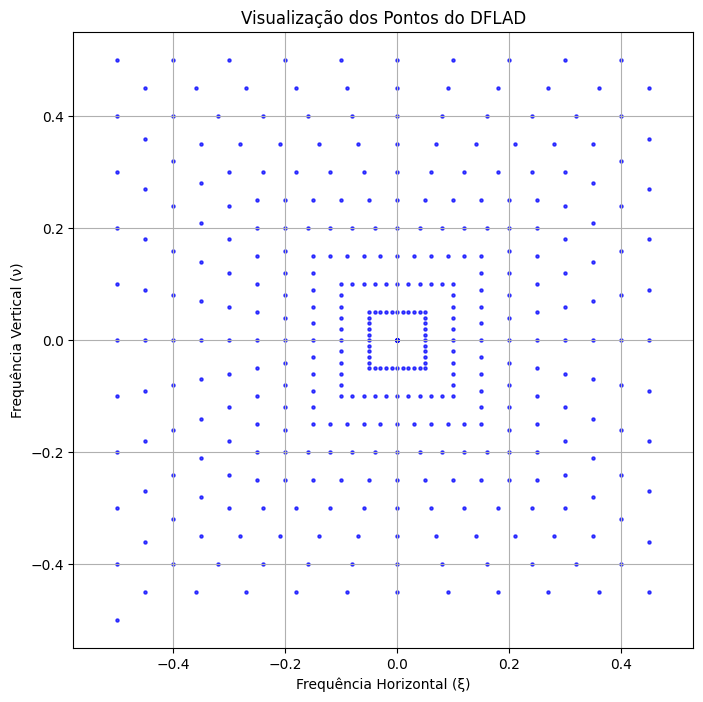

In [ ]:
visualizar_dominio(linogram_coords)